In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bemcs
import utilfunctions as UF
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Input file and mesh geometry
Provide an input file with mesh endpoints and boundary condition labels. In this notebook we compute stress changes induced by non-planar topography only i.e., there is NO fault in this example.

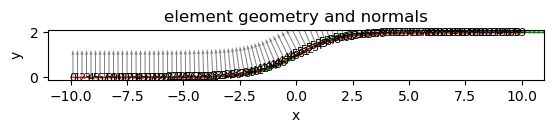

In [14]:
Lscale = 10
npts = 101
hmax = 2
xvals = np.linspace(-Lscale, Lscale, npts)
yvals = UF.logistic(xvals, L=hmax, k=1, x0=0)

x1 = xvals[0:-1]
x2 = xvals[1:]
y1 = yvals[0:-1]
y2 = yvals[1:]
BCtype = np.array([f"t_global" for i in range(npts - 1)])

# Elastic parameters and lithostatic effects
mu = 1  # in GPa
nu = 0.25  # Poisson's ratio
rho = 1  # normally in kg/m^3 but divide by 1e3 so that rho*g*y is in MPa (note y is in km) - rho*g/mu
ydatum = 0  # provide a datum in km
# construct mesh
els = bemcs.initialize_els()
stride = 6

els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2

bemcs.standardize_els_geometry(els, reorder=True)
# compute topographic load
BCval = rho * (els.y_centers - ydatum)

n_els = len(els.x1)
bemcs.plot_els_geometry(els)

In [15]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = stride * n_els
# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
bc_x = nu / (1 - nu) * BCval * els.x_normals
bc_y = BCval * els.y_normals

BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(
    els.x_centers, els.y_centers, els, mu, nu, "shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    els.x_centers, els.y_centers, els, mu, nu, "normal"
)

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

kerneleval_x, kerneleval_y = UF.kernel_constructor(
    els,
    BCtype,
    BCtype,
    kernels_s,
    kernels_n,
    traction_kernels_s,
    traction_kernels_n,
)
# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

Number of open nodes = 2
: [array([0]), array([299])]
Number of 2-overlap nodes = 99
: [array([ 3, -2]), array([ 6, -5]), array([ 9, -8]), array([ 12, -11]), array([ 15, -14]), array([ 18, -17]), array([ 21, -20]), array([ 24, -23]), array([ 27, -26]), array([ 30, -29]), array([ 33, -32]), array([ 36, -35]), array([ 39, -38]), array([ 42, -41]), array([ 45, -44]), array([ 48, -47]), array([ 51, -50]), array([ 54, -53]), array([ 57, -56]), array([ 60, -59]), array([ 63, -62]), array([ 66, -65]), array([ 69, -68]), array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([ 96, -95]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 120, -119]), array([ 123, -122]), array([ 126, -125]), array([ 129, -128]), array([ 132, -131]), array([ 135, -134]), array([ 138, -137]), array([ 141, -140]

# Solve linear system of equations and get solution coeffcients (on the boundary)

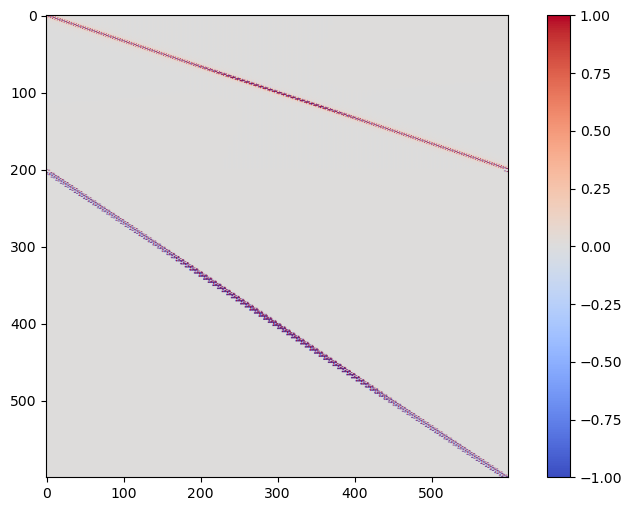

Linear Operator Condition Number: 2754.11318572847


In [16]:
matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)
# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(10, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.solve(matrix_system, BCvector)
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

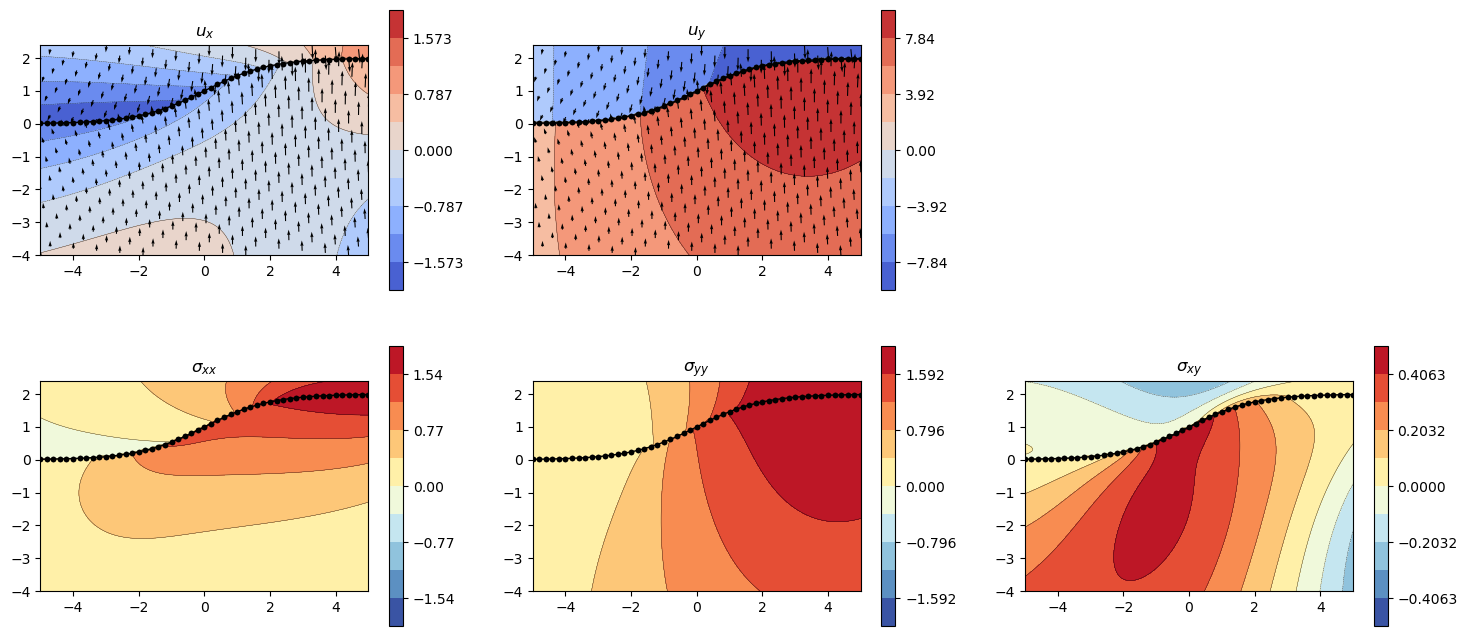

In [17]:
# Observation points
n_obs = 100

x_obs = np.linspace(Lscale * -0.5, Lscale * 0.5, n_obs)
y_obs = np.linspace(-2 * hmax, 1.2 * hmax, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=31
)

# Plot your favorite scalar representation of the stress field

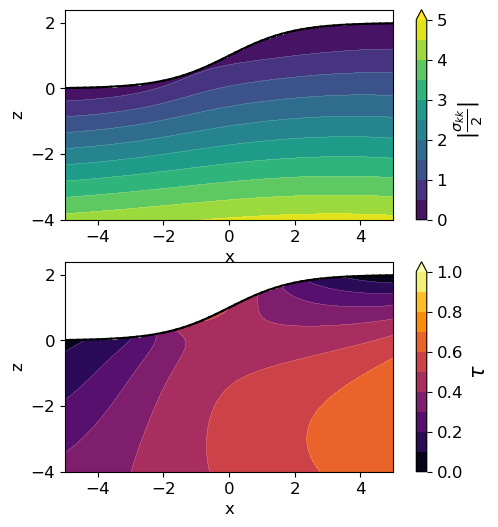

In [21]:
# first remove all values above topography
index = bemcs.inpolygon(
    x_obs,
    y_obs,
    np.hstack((els.x_centers, 100, 100, -100)),
    np.hstack((els.y_centers, 10, -10, -10)),
)


plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
# plot pressure term
toplot = np.abs((sxx + syy) / 2 - rho * (y_obs.reshape(-1, 1) - ydatum))
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
# provide min/max values to plot
maxval = 5.0  # rho * ydatum
minval = 0
levels = np.linspace(minval, maxval, 11)
n_skip_plot = 1
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="viridis",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    extend="max",
)
# plt.clim([minval, maxval])
cb = plt.colorbar(img, shrink=1.0, extend="max")
cb.ax.tick_params(labelsize=12)
cb.set_label("$|\\frac{\\sigma_{kk}}{2}|$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="white",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.1,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([-0.5 * Lscale, 0.5 * Lscale])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 1, 2)
# plot second invariant of stress
toplot = np.sqrt(1 / 4 * (sxx - syy) ** 2 + sxy**2)
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
# provide min/max values to plot
maxval = 1.0  # rho * ydatum
minval = 0
levels = np.linspace(minval, maxval, 11)
n_skip_plot = 1
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="inferno",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    extend="max",
)
# plt.clim([minval, maxval])
cb = plt.colorbar(img, shrink=1.0, extend="max")
cb.ax.tick_params(labelsize=12)
cb.set_label("$\\tau$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="white",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.1,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([-0.5 * Lscale, 0.5 * Lscale])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()